# 日本の選挙当落予測（ダミーデータ・マルチモーダル）
**目的**: SNSテキスト（日本語）・数値属性・簡易画像特徴（ポスター色）を統合したマルチモーダルモデルで、当選/落選を**ダミーデータ**で学習・評価します。

> **重要**
> - 本ノートブックは *完全に合成されたダミーデータ* を用いる学術・教育目的のデモです。
> - 実際の選挙や特定の候補・政党に関する推定・助言・キャンペーン用途には **絶対に使用しない** でください。
> - 倫理・法令・プラットフォーム規約を遵守してください。

---
## 構成
1. 依存関係のセットアップ（unidic-lite）
2. ダミーデータ生成（テキスト/SNS指標・数値・簡易画像）
3. 可視化と前処理（日本語分かち書き→TF-IDF）
4. 特色融合（テキスト疎行列＋数値/画像の密ベクトル）
5. ベースライン: ロジスティック回帰（sklearn）
6. シンプル多層パーセプトロン（PyTorch; 早期終了）
7. 推論ユーティリティ＆モデル保存/ダウンロード


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/test/

Mounted at /content/drive
/content/drive/MyDrive/test


In [2]:
# 1) 依存関係セットアップ（unidic-lite版）
!pip -q install "fugashi[unidic-lite]" sentencepiece scikit-learn pandas numpy matplotlib seaborn pillow torch torchvision

import os, random, math, io, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from scipy.sparse import hstack, csr_matrix

# 日本語分かち書き（fugashi + unidic-lite）
from fugashi import Tagger
try:
    tagger = Tagger()  # unidic-liteが自動認識される
except Exception as e:
    print('Tagger初期化で例外:', e)
    # フォールバック（wakati出力）
    tagger = Tagger('-Owakati')

# 動作確認（辞書ロード）
print('分かち書きテスト:', [w.surface for w in tagger('テストとして日本語の文章を分かち書きします。')])

random.seed(42)
np.random.seed(42)
os.makedirs('posters', exist_ok=True)

print('セットアップ完了（unidic-lite使用）')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 6.9 MB/s eta 0:00:00
分かち書きテスト: ['テスト', 'と', 'し', 'て', '日本', '語', 'の', '文章', 'を', '分かち書き', 'し', 'ます', '。']
セットアップ完了（unidic-lite使用）


In [3]:
# 2) ダミーデータ生成

N = 600  # 候補の件数（ダミー）
districts = [f'District_{i}' for i in range(1, 51)]
parties = ['Party_A','Party_B','Party_C','Party_D']  # 実在政党名は使いません

# SNSテキストテンプレート（中立・一般論）
text_templates = [
    '地域の課題に取り組みます。皆さんの声を政策に反映します。',
    '安心安全なまちづくり、教育・福祉を充実させます。',
    '小さな声を大切に、持続可能な地域をめざします。',
    '透明性の高い行政と効率的な予算運用を推進します。',
    '防災・減災を強化し、暮らしを守ります。',
]

extra_tokens = ['応援お願いします','ボランティア募集中','ライブ配信します','政策意見募集中','説明会を開催']

def make_dummy_text():
    t = random.choice(text_templates)
    extra = random.choice(extra_tokens)
    return f"{t} {extra}"

def make_poster(candidate_id):
    # シンプルな単色ポスターを生成し、平均色RGBを特徴にします
    w,h = 256, 256
    base_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    img = Image.new('RGB', (w,h), base_color)
    draw = ImageDraw.Draw(img)
    # テキスト描画（フォントはColabの標準）
    msg = f'ID {candidate_id}'
    draw.text((10, 10), msg, fill=(255-base_color[0], 255-base_color[1], 255-base_color[2]))
    path = os.path.join('posters', f'poster_{candidate_id}.png')
    img.save(path)
    # 平均色を特徴量に
    arr = np.array(img)
    mean_rgb = arr.mean(axis=(0,1))  # R,G,B
    return path, mean_rgb

records = []
for i in range(N):
    candidate_id = i
    district = random.choice(districts)
    party = random.choice(parties)
    age = np.random.randint(25, 75)
    incumbency = np.random.binomial(1, 0.45)  # 現職ダミー
    prior_vote_share = np.random.uniform(0.2, 0.8)  # 前回得票率（ダミー）
    poll_trend = np.random.normal(0, 1)  # 世論の傾向指標（ダミー）
    sns_posts = make_dummy_text()
    sns_likes = np.random.poisson(200)
    sns_shares = np.random.poisson(50)
    poster_path, mean_rgb = make_poster(candidate_id)
    r,g,b = mean_rgb.tolist()
    # 当落ラベル（ダミー生成）：いくつかの要因から確率を作る
    logit = (
        1.0*incumbency +
        0.8*prior_vote_share +
        0.2*poll_trend +
        0.001*sns_likes +
        0.002*sns_shares +
        0.0005*(r+g+b-382)  # 色の遊び（平均382付近ならプラス）
    )
    prob = 1/(1+math.exp(-logit))
    won = np.random.binomial(1, min(max(prob,0.01),0.99))

    records.append({
        'candidate_id': candidate_id, 'district': district, 'party': party, 'age': age,
        'incumbency': incumbency, 'prior_vote_share': prior_vote_share, 'poll_trend': poll_trend,
        'sns_posts': sns_posts, 'sns_likes': sns_likes, 'sns_shares': sns_shares,
        'poster_path': poster_path, 'poster_r': r, 'poster_g': g, 'poster_b': b,
        'won': won
    })

df = pd.DataFrame(records)
df.head()


,candidate_id,district,party,age,incumbency,prior_vote_share,poll_trend,sns_posts,sns_likes,sns_shares,poster_path,poster_r,poster_g,poster_b,won
0,0,District_41,Party_A,63,1,0.310061,0.473861,地域の課題に取り組みます。皆さんの声を政策に反映します。 ライブ配信します,198,49,posters/poster_0.png,125.003326,114.017380,71.072952,1
1,1,District_48,Party_A,27,0,0.781946,1.368450,防災・減災を強化し、暮らしを守ります。 応援お願いします,216,43,posters/poster_1.png,215.903015,16.122055,15.123184,1
2,2,District_6,Party_B,46,0,0.213837,-2.439106,安心安全なまちづくり、教育・福祉を充実させます。 説明会を開催,188,52,posters/poster_2.png,13.138321,101.032013,213.895554,1
3,3,District_15,Party_D,27,1,0.608185,0.603441,防災・減災を強化し、暮らしを守ります。 ライブ配信します,198,65,posters/poster_3.png,3.155106,81.058060,215.889603,1
4,4,District_22,Party_C,50,0,0.610540,-1.021552,安心安全なまちづくり、教育・福祉を充実させます。 ボランティア募集中,200,61,posters/poster_4.png,171.944016,52.094803,47.101212,0


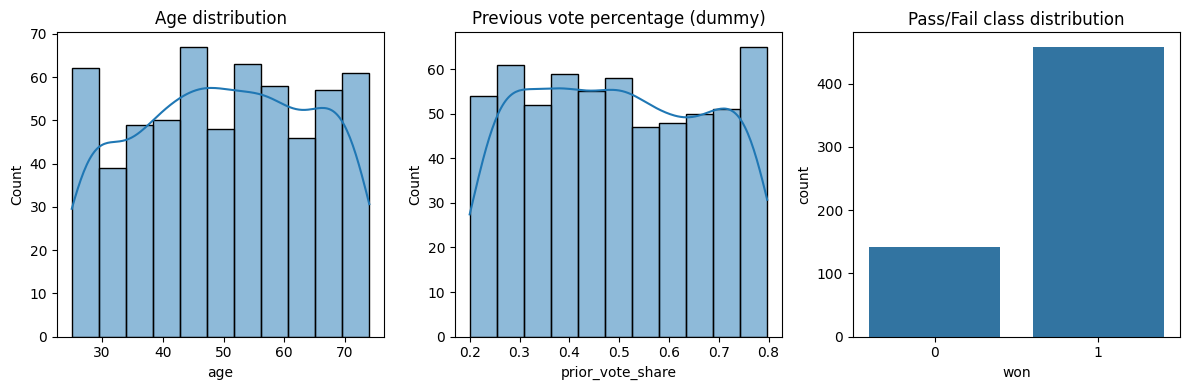

,candidate_id,poster_path,sns_posts
0,0,posters/poster_0.png,地域の課題に取り組みます。皆さんの声を政策に反映します。 ライブ配信します
1,1,posters/poster_1.png,防災・減災を強化し、暮らしを守ります。 応援お願いします
2,2,posters/poster_2.png,安心安全なまちづくり、教育・福祉を充実させます。 説明会を開催


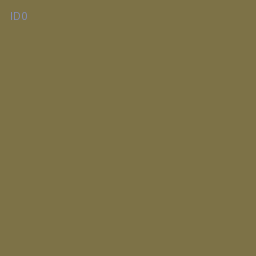

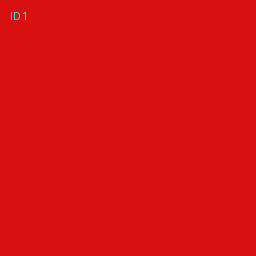

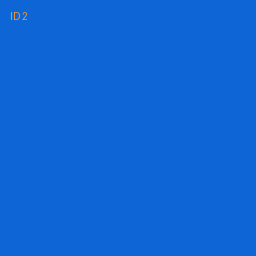

In [4]:
# 3) 可視化

fig, axes = plt.subplots(1, 3, figsize=(12,4))
sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title('Age distribution')
sns.histplot(df['prior_vote_share'], kde=True, ax=axes[1])
axes[1].set_title('Previous vote percentage (dummy)')
sns.countplot(x='won', data=df, ax=axes[2])
axes[2].set_title('Pass/Fail class distribution')
plt.tight_layout()
plt.show()

# ポスター例の表示
display(df[['candidate_id','poster_path','sns_posts']].head(3))
from IPython.display import Image as IPyImage
for p in df['poster_path'].head(3):
    display(IPyImage(filename=p))


In [5]:
# 4) 日本語前処理 → TF-IDF

# フォールバック付きトークナイザ
import re

def jp_tokenizer(text: str):
    try:
        return [w.surface for w in tagger(text)]
    except Exception:
        return re.findall(r'[一-龥ぁ-んァ-ンーa-zA-Z0-9]+', text)

# Vectorizer
tfidf = TfidfVectorizer(
    tokenizer=jp_tokenizer,
    max_features=500,  # 語彙数を制限
    min_df=2,
    ngram_range=(1,2)
)
X_text = tfidf.fit_transform(df['sns_posts'])
print('TF-IDF形状:', X_text.shape)

# 数値・画像特徴
num_cols = ['age','incumbency','prior_vote_share','poll_trend','sns_likes','sns_shares','poster_r','poster_g','poster_b']
X_num = df[num_cols].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# 疎＋密の結合
X = hstack([X_text, csr_matrix(X_num_scaled)])
y = df['won'].values
print('融合特徴形状:', X.shape)


TF-IDF形状: (600, 136)
融合特徴形状: (600, 145)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.753, ROC-AUC: 0.681
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.76      0.99      0.86       114

    accuracy                           0.75       150
   macro avg       0.38      0.50      0.43       150
weighted avg       0.58      0.75      0.65       150



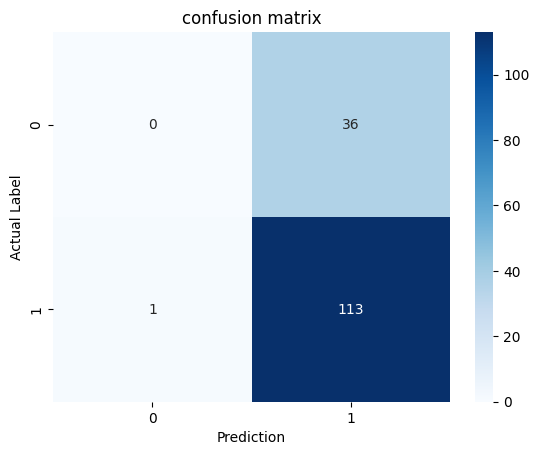

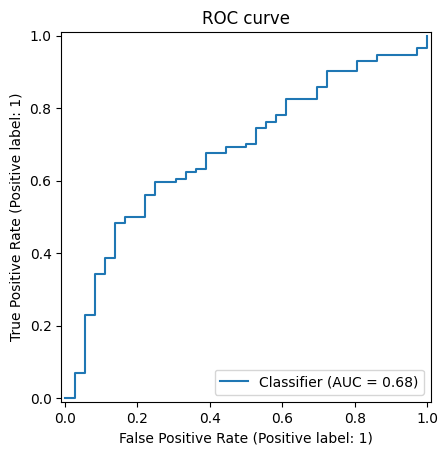

In [6]:
# 5) ベースライン: ロジスティック回帰

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# solverはliblinearで安定動作（L2正則化）
clf = LogisticRegression(max_iter=200, solver='liblinear')
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)
print(f'Accuracy: {acc:.3f}, ROC-AUC: {auc:.3f}')
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual Label')
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title('ROC curve')
plt.show()


In [7]:
# 6) MLP（PyTorch）

import torch
import torch.nn as nn
import torch.optim as optim

# スパース→Denseに変換（語彙数を制限しているので可）
X_dense = X.toarray().astype(np.float32)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dense, y, test_size=0.25, random_state=42, stratify=y)

X_train_t = torch.tensor(X_train_d)
y_train_t = torch.tensor(y_train_d.astype(np.float32))
X_test_t = torch.tensor(X_test_d)
y_test_t = torch.tensor(y_test_d.astype(np.float32))

class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X_train_t.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val = 0.0
best_state = None
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_t).squeeze()
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        val_out = model(X_test_t).squeeze()
        val_pred = (val_out.numpy() >= 0.5).astype(int)
        val_acc = (val_pred == y_test_d).mean()
        print(f'Epoch {epoch+1}: loss={loss.item():.4f}, val_acc={val_acc:.3f}')
        if val_acc > best_val:
            best_val = val_acc
            best_state = model.state_dict()

if best_state is not None:
    model.load_state_dict(best_state)

# 評価（ROC-AUC）
with torch.no_grad():
    proba_t = model(X_test_t).squeeze().numpy()
auc_mlp = roc_auc_score(y_test_d, proba_t)
print(f'MLP ROC-AUC: {auc_mlp:.3f}')


Epoch 1: loss=0.7049, val_acc=0.600
Epoch 2: loss=0.6909, val_acc=0.753
Epoch 3: loss=0.6781, val_acc=0.760
Epoch 4: loss=0.6650, val_acc=0.760
Epoch 5: loss=0.6533, val_acc=0.760
Epoch 6: loss=0.6405, val_acc=0.760
Epoch 7: loss=0.6272, val_acc=0.760
Epoch 8: loss=0.6145, val_acc=0.760
Epoch 9: loss=0.6031, val_acc=0.760
Epoch 10: loss=0.5902, val_acc=0.760
Epoch 11: loss=0.5795, val_acc=0.760
Epoch 12: loss=0.5656, val_acc=0.760
Epoch 13: loss=0.5578, val_acc=0.760
Epoch 14: loss=0.5478, val_acc=0.760
Epoch 15: loss=0.5413, val_acc=0.760
Epoch 16: loss=0.5340, val_acc=0.760
Epoch 17: loss=0.5344, val_acc=0.760
Epoch 18: loss=0.5287, val_acc=0.760
Epoch 19: loss=0.5306, val_acc=0.760
Epoch 20: loss=0.5237, val_acc=0.760
Epoch 21: loss=0.5361, val_acc=0.760
Epoch 22: loss=0.5243, val_acc=0.760
Epoch 23: loss=0.5312, val_acc=0.760
Epoch 24: loss=0.5257, val_acc=0.760
Epoch 25: loss=0.5256, val_acc=0.760
Epoch 26: loss=0.5203, val_acc=0.760
Epoch 27: loss=0.5203, val_acc=0.760
Epoch 28: 

In [8]:
# 7) 推論

from scipy.sparse import hstack, csr_matrix

def predict_outcome(sns_text, age, incumbency, prior_vote_share, poll_trend, sns_likes, sns_shares, rgb_tuple):
    # テキストをTF-IDFに
    X_text_new = tfidf.transform([sns_text])
    # 数値
    X_num_new = np.array([[age,incumbency,prior_vote_share,poll_trend,sns_likes,sns_shares,rgb_tuple[0],rgb_tuple[1],rgb_tuple[2]]])
    X_num_new_scaled = scaler.transform(X_num_new)
    X_new = hstack([X_text_new, csr_matrix(X_num_new_scaled)])
    # ロジスティック回帰で確率
    proba_lr = clf.predict_proba(X_new)[:,1][0]
    pred_lr = int(proba_lr >= 0.5)
    return {'pred_lr': pred_lr, 'proba_lr': float(proba_lr)}

example = predict_outcome(
    '地域の課題に取り組みます。応援お願いします', 45, 1, 0.55, 0.2, 250, 60, (120,180,200)
)
print('例の推論結果:', example)


例の推論結果: {'pred_lr': 1, 'proba_lr': 0.8063103267893585}


In [9]:
# 8) 保存とダウンロード

df.to_csv('/content/drive/MyDrive/test/dummy_election_multimodal_dataset.csv', index=False)
import joblib
joblib.dump(clf, 'baseline_logreg.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(tfidf, 'tfidf.pkl')
print('CSVとモデルを保存')

# Colabでのダウンロードヘルパ
try:
    from google.colab import files
    files.download('dummy_election_multimodal_dataset.csv')
    files.download('baseline_logreg.pkl')
    files.download('scaler.pkl')
    files.download('tfidf.pkl')
except Exception as e:
    print('ローカル環境では手動でファイルを取得してください:', e)


CSVとモデルを保存


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>